## Analysis VCoG Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf
import json
# -------------------------------------------------
# LOAD CONFIG
# -------------------------------------------------
config_path = "config.yaml"
config = OmegaConf.load(config_path)
folder_path = Path(config.renamed_output_path)


json_path = Path(config.json_path)
# Output directory
output_dir = Path(config.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
# -------------------------------------------------

# -------------------------------------------------
# FIND ALL VCOG FILES
# -------------------------------------------------
vcog_files = list(folder_path.glob("*VCoG*.csv"))
print(f"🔍 Found {len(vcog_files)} VCOG files")

for i, file in enumerate(vcog_files, 1):
    #print(f"⚙ loading → {file.name}")
    df = pd.read_csv(file)
    globals()[f"df{i}_VC"] = df
    print(f"✅ loaded → {file.name} with name df{i}_VC")

# -------------------------------------------------
# FIND ALL CCOG FILES
# -------------------------------------------------
ccog_files = list(folder_path.glob("*CCoG*.csv"))
print(f"🔍 Found {len(ccog_files)} CCOG files")

for i, file in enumerate(ccog_files, 1):
    #print(f"⚙ loading → {file.name}")
    df = pd.read_csv(file)
    globals()[f"df{i}_CC"] = df
    print(f"✅ loaded → {file.name} with name df{i}_CC")


🔍 Found 5 VCOG files
✅ loaded → Exp_1_VCoG_TOC_renamed.csv with name df1_VC
✅ loaded → Exp_2_VCoG_TOC_EW_renamed.csv with name df2_VC
✅ loaded → Exp_3_VCoG_2m_OL_Ncable_WE_renamed.csv with name df3_VC
✅ loaded → Exp_4_VCoG_4m_OL_Ncable_EW_renamed.csv with name df4_VC
✅ loaded → Exp_5_VCoG_6m_OL_Ncable_WE_renamed.csv with name df5_VC
🔍 Found 5 CCOG files
✅ loaded → Exp_1_CCoG_TOC_renamed.csv with name df1_CC
✅ loaded → Exp_2_CCoG_TOC_EW_renamed.csv with name df2_CC
✅ loaded → Exp_3_CCoG_2m_OL_Ncable_WE_renamed.csv with name df3_CC
✅ loaded → Exp_4_CCoG_4m_OL_Ncable_EW_renamed.csv with name df4_CC
✅ loaded → Exp_5_CCoG_6m_OL_Ncable_WE_renamed.csv with name df5_CC


In [2]:
df1_VC

,Timestamp_Epoch,Timestamp_Seconds,Cart_X,Cart_Y,Cart_Z,Yaw_angle,Cable_X,Cable_Y,Unused,Cable_Lock
0,1.759745e+09,120030.777,619487.27,5806174.64,41.54,-87.9,7.2,2.9,NaN,1
1,1.759745e+09,120030.980,619487.27,5806174.64,41.54,-87.9,7.2,2.9,NaN,1
2,1.759745e+09,120031.200,619487.27,5806174.64,41.54,-87.9,7.2,2.9,NaN,1
3,1.759745e+09,120031.401,619487.27,5806174.64,41.54,-87.9,7.2,2.9,NaN,1
4,1.759745e+09,120031.603,619487.27,5806174.64,41.54,-87.9,7.2,2.9,NaN,1
...,...,...,...,...,...,...,...,...,...,...
3921,1.759746e+09,121334.903,619487.62,5806174.71,41.60,-88.8,7.0,3.4,NaN,1
3922,1.759746e+09,121335.107,619487.61,5806174.71,41.59,-88.7,7.1,3.4,NaN,1
3923,1.759746e+09,121335.311,619487.61,5806174.71,41.59,-88.8,7.1,3.3,NaN,1
3924,1.759746e+09,121335.516,619487.61,5806174.71,41.59,-88.8,7.1,3.3,NaN,1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_fix_data(vcog_path, ccog_path):
    # 1. Ingest Data (No headers, so we infer them)
    df_vcog = pd.read_csv(vcog_path)
    df_ccog = pd.read_csv(ccog_path)

    # 2. Extract Coordinates (Based on Data Intuition)
    # VCOG Cols: 2=Easting, 3=Northing
    cart_pos = df_vcog.iloc[:, [2, 3]].values
    
    # CCOG Cols: 2=Easting, 3=Northing
    bad_cable_pos = df_ccog.iloc[:, [2, 3]].values

    # 3. The Mathematical Fix
    # The error is a 180-degree heading flip. 
    # This means the offset vector (Cart -> Cable) is pointing in the exact opposite direction.
    # Fix: Invert the offset vector.
    
    # Vector from Cart to Bad Cable
    offset_vector_bad = bad_cable_pos - cart_pos
    
    # Correct Vector = -1 * Bad Vector
    offset_vector_good = -1 * offset_vector_bad
    
    # Reconstruct True Position
    true_cable_pos = cart_pos + offset_vector_good
    
    return cart_pos, bad_cable_pos, true_cable_pos

def visualize_correction(cart, bad, good, title_suffix=""):
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Full Path
    plt.subplot(1, 2, 1)
    plt.plot(cart[:, 0], cart[:, 1], label='Cart Path', c='blue', alpha=0.6)
    plt.plot(bad[:, 0], bad[:, 1], label='Reported Cable (Error)', c='red', alpha=0.6)
    plt.plot(good[:, 0], good[:, 1], label='Corrected Cable', c='green', alpha=0.6)
    plt.title("Full Experiment Path")
    plt.axis('equal')
    plt.legend()
    
    # Plot 2: Zoom in (First 50 points) to show the vector flip
    subset = 40
    plt.subplot(1, 2, 2)
    plt.plot(cart[:subset, 0], cart[:subset, 1], '.-', label='Cart', c='blue')
    plt.plot(bad[:subset, 0], bad[:subset, 1], 'x--', label='Reported', c='red')
    plt.plot(good[:subset, 0], good[:subset, 1], 'o--', label='Corrected', c='green')
    
    # Draw connection lines to visualize vectors
    for i in range(0, subset, 5):
        plt.plot([cart[i,0], bad[i,0]], [cart[i,1], bad[i,1]], 'r-', alpha=0.2)
        plt.plot([cart[i,0], good[i,0]], [cart[i,1], good[i,1]], 'g-', alpha=0.2)
        
    plt.title("Zoomed Detail: The 180° Flip")
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    # save figure in output directory 
    plt.savefig(output_dir / f"correction_visualization{title_suffix}.png")
    plt.show()


Processing VCoG: Exp_1_VCoG_TOC_renamed.csv with CCoG: Exp_1_CCoG_TOC_renamed.csv


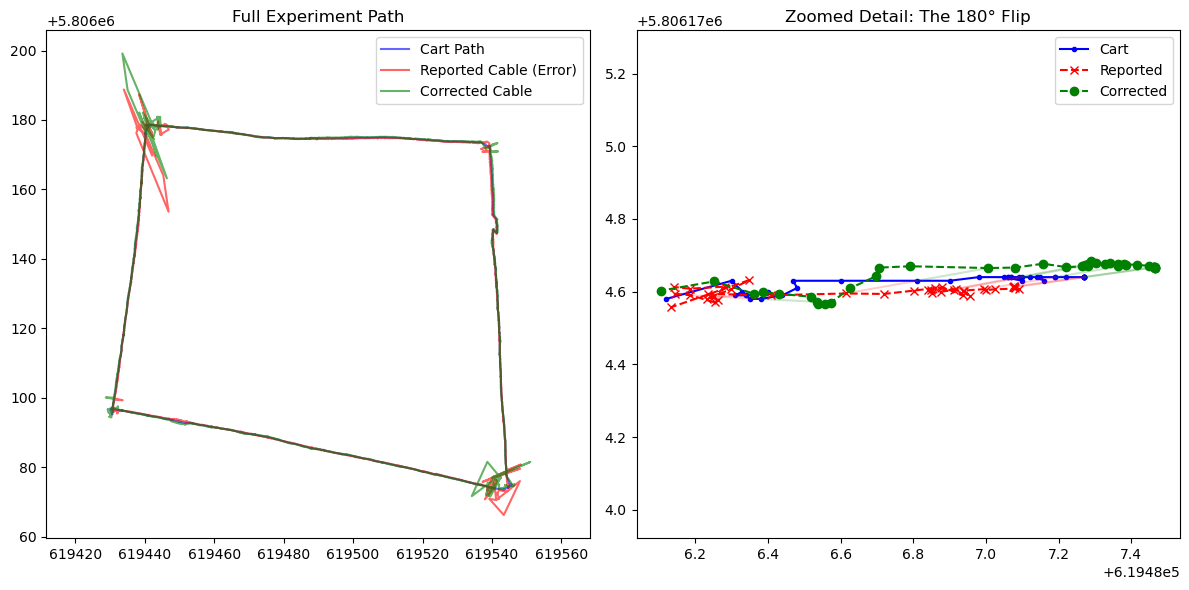

Processing VCoG: Exp_2_VCoG_TOC_EW_renamed.csv with CCoG: Exp_2_CCoG_TOC_EW_renamed.csv


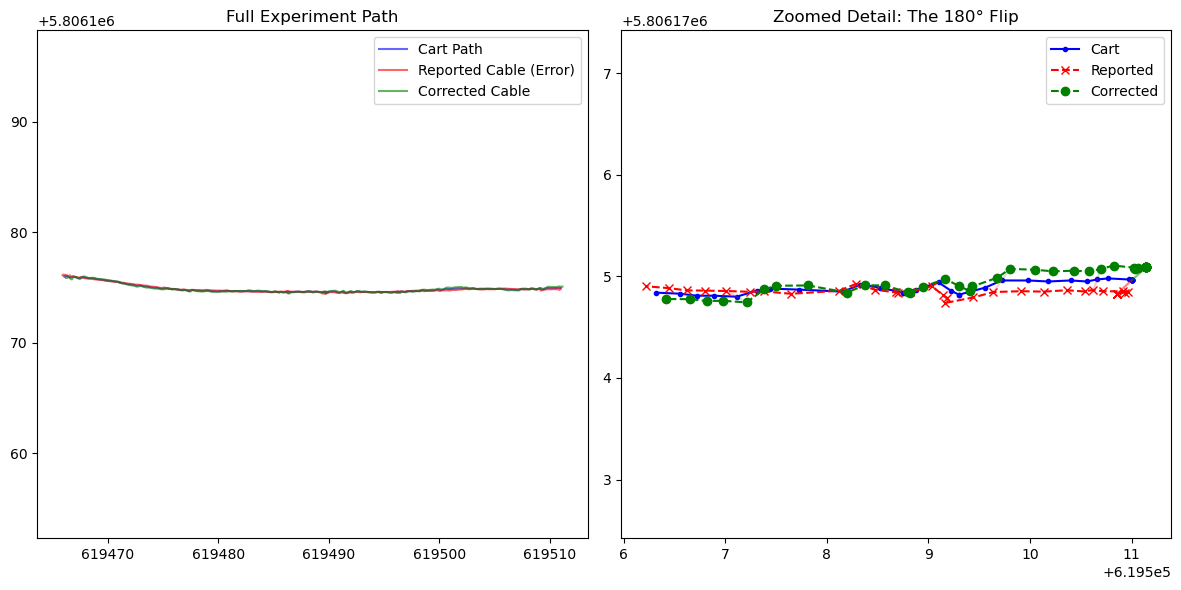

Processing VCoG: Exp_3_VCoG_2m_OL_Ncable_WE_renamed.csv with CCoG: Exp_3_CCoG_2m_OL_Ncable_WE_renamed.csv


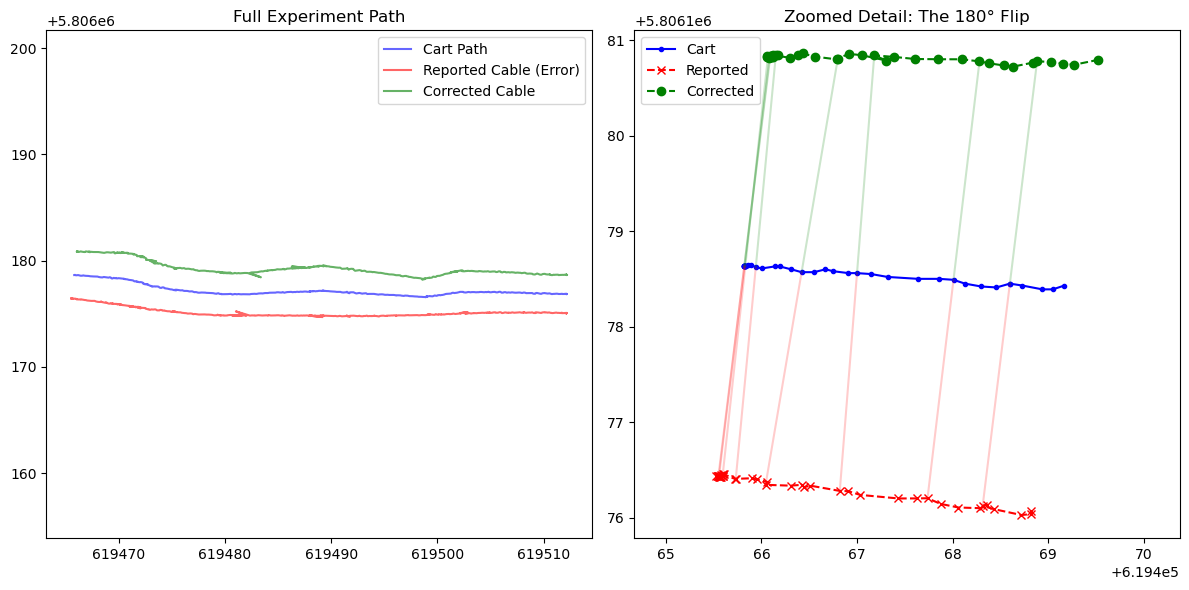

Processing VCoG: Exp_4_VCoG_4m_OL_Ncable_EW_renamed.csv with CCoG: Exp_4_CCoG_4m_OL_Ncable_EW_renamed.csv


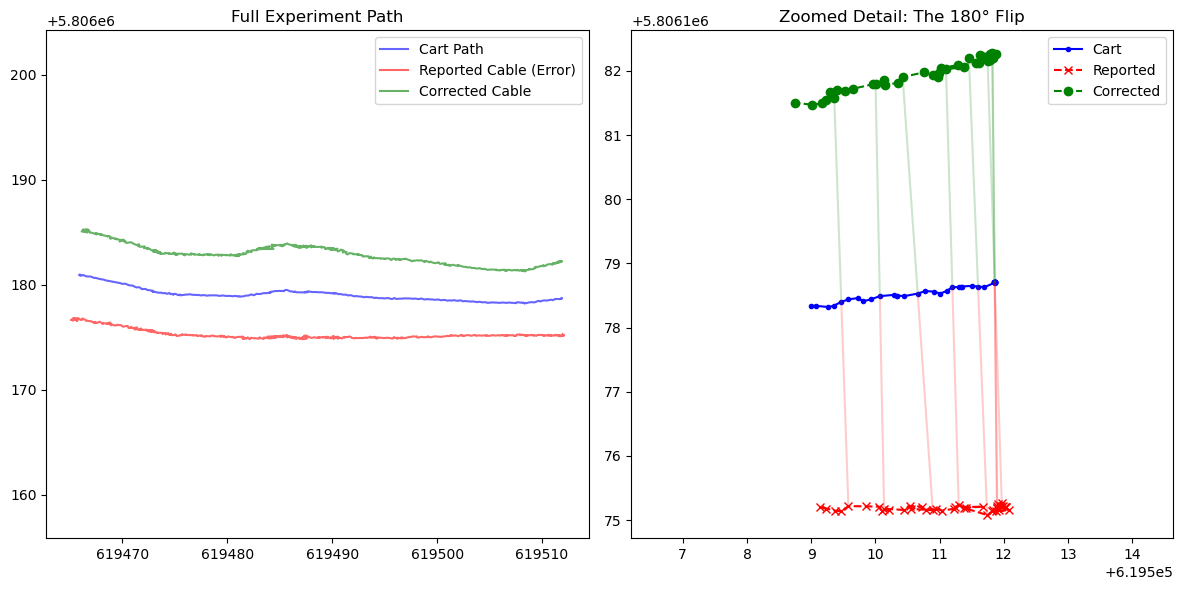

Processing VCoG: Exp_5_VCoG_6m_OL_Ncable_WE_renamed.csv with CCoG: Exp_5_CCoG_6m_OL_Ncable_WE_renamed.csv


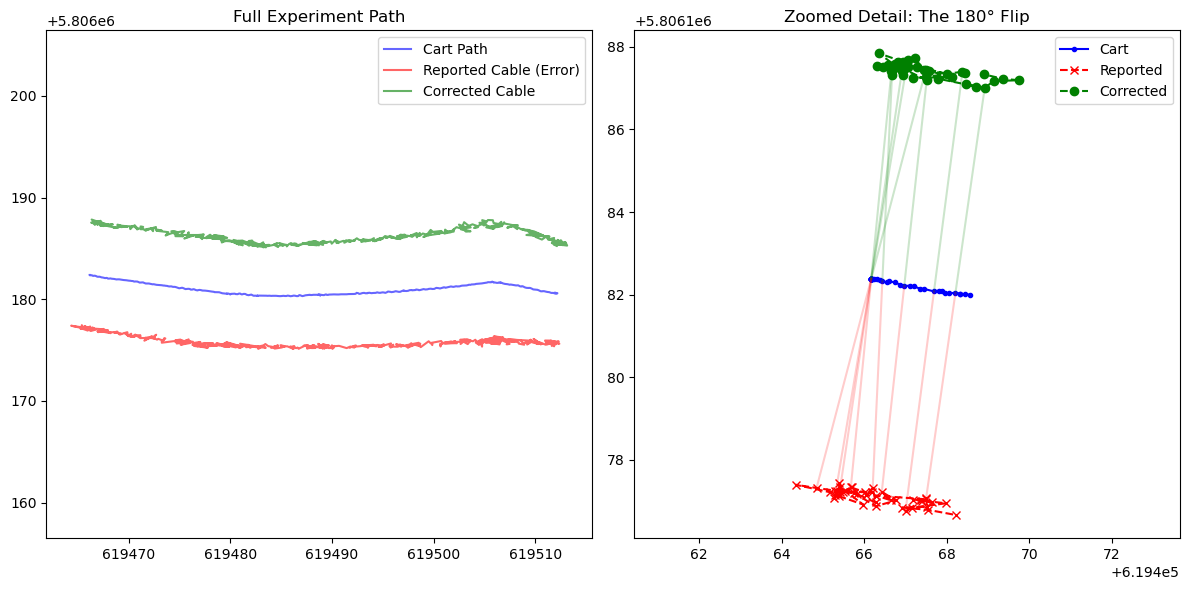

In [4]:
for vcog_file, ccog_file in zip(vcog_files, ccog_files):
    print(f"Processing VCoG: {vcog_file.name} with CCoG: {ccog_file.name}")
    cart, bad, good = load_and_fix_data(vcog_file, ccog_file)
    visualize_correction(cart, bad, good, title_suffix=f"_{vcog_file.stem}")
